<a href="https://colab.research.google.com/github/AliShcherb/AliShcherb.github.io/blob/side/BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!apt-get update -qq
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [9]:


from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SocialFactorsDepression") \
    .getOrCreate()

print("PySpark is ready!")


PySpark is ready!


In [13]:
from google.colab import files

uploaded = files.upload()

import os
print(os.listdir('.'))


Saving ESS11.csv to ESS11.csv
['.config', 'ESS11.csv', 'sample_data']


In [16]:
df = spark.read.csv("ESS11.csv", header=True, inferSchema=True)

df.printSchema()

df.show(5)


root
 |-- name: string (nullable = true)
 |-- essround: integer (nullable = true)
 |-- edition: double (nullable = true)
 |-- proddate: string (nullable = true)
 |-- idno: integer (nullable = true)
 |-- cntry: string (nullable = true)
 |-- dweight: double (nullable = true)
 |-- pspwght: double (nullable = true)
 |-- pweight: double (nullable = true)
 |-- anweight: double (nullable = true)
 |-- nwspol: integer (nullable = true)
 |-- netusoft: integer (nullable = true)
 |-- netustm: integer (nullable = true)
 |-- ppltrst: integer (nullable = true)
 |-- pplfair: integer (nullable = true)
 |-- pplhlp: integer (nullable = true)
 |-- polintr: integer (nullable = true)
 |-- psppsgva: integer (nullable = true)
 |-- actrolga: integer (nullable = true)
 |-- psppipla: integer (nullable = true)
 |-- cptppola: integer (nullable = true)
 |-- trstprl: integer (nullable = true)
 |-- trstlgl: integer (nullable = true)
 |-- trstplc: integer (nullable = true)
 |-- trstplt: integer (nullable = true)
 |-- 

In [17]:
columns_of_interest = [
    "cntry",      # Країна
    "agea",       # Вік
    "gndr",       # Стать
    "edulvlb",    # Освітній рівень
    "hinctnta",   # Доходи
    "fltdpr",     # Відчуття депресії
    "stflife",    # Задоволеність життям
    "health"      # Самооцінка здоров'я
]


selected_df = df.select(columns_of_interest)

selected_df.show(5)



+-----+----+----+-------+--------+------+-------+------+
|cntry|agea|gndr|edulvlb|hinctnta|fltdpr|stflife|health|
+-----+----+----+-------+--------+------+-------+------+
|   AT|  65|   1|    322|       6|     1|      8|     3|
|   AT|  21|   2|    423|       1|     2|      9|     2|
|   AT|  53|   2|    610|       5|     2|     10|     1|
|   AT|  78|   2|    422|       2|     2|      7|     3|
|   AT|  64|   1|    322|      77|     1|      9|     2|
+-----+----+----+-------+--------+------+-------+------+
only showing top 5 rows



In [18]:
print(df.columns)

['name', 'essround', 'edition', 'proddate', 'idno', 'cntry', 'dweight', 'pspwght', 'pweight', 'anweight', 'nwspol', 'netusoft', 'netustm', 'ppltrst', 'pplfair', 'pplhlp', 'polintr', 'psppsgva', 'actrolga', 'psppipla', 'cptppola', 'trstprl', 'trstlgl', 'trstplc', 'trstplt', 'trstprt', 'trstep', 'trstun', 'vote', 'prtvtdat', 'prtvtebe', 'prtvtchr', 'prtvtccy', 'prtvtffi', 'prtvtffr', 'prtvgde1', 'prtvgde2', 'prtvtegr', 'prtvthhu', 'prtvteis', 'prtvteie', 'prtvteit', 'prtvclt1', 'prtvclt2', 'prtvclt3', 'prtvtinl', 'prtvtcno', 'prtvtfpl', 'prtvtept', 'prtvtbrs', 'prtvtesk', 'prtvtgsi', 'prtvtges', 'prtvtdse', 'prtvthch', 'prtvtdgb', 'contplt', 'donprty', 'badge', 'sgnptit', 'pbldmna', 'bctprd', 'pstplonl', 'volunfp', 'clsprty', 'prtcleat', 'prtclebe', 'prtclbhr', 'prtclccy', 'prtclgfi', 'prtclgfr', 'prtclgde', 'prtclegr', 'prtclihu', 'prtcleis', 'prtclfie', 'prtclfit', 'prtclclt', 'prtclhnl', 'prtclcno', 'prtcljpl', 'prtclgpt', 'prtclbrs', 'prtclesk', 'prtclgsi', 'prtclhes', 'prtcldse', 'p

In [25]:
clean_df = selected_df.na.drop().dropDuplicates()
print(f"Кількість записів після очищення: {clean_df.count()}")


Кількість записів після очищення: 39638


Фаза 1


In [26]:
from pyspark.sql.functions import when, col
#Mapper-функція
clean_df = clean_df.withColumn(
    "age_group",
    when(col("agea") < 30, "Under 30")
    .when((col("agea") >= 30) & (col("agea") < 50), "30-49")
    .when(col("agea") >= 50, "50+")
    .otherwise("Unknown")
)

clean_df.select("agea", "age_group").show(10)


+----+---------+
|agea|age_group|
+----+---------+
|  47|    30-49|
|  70|      50+|
|  50|      50+|
|  33|    30-49|
|  76|      50+|
|  25| Under 30|
|  49|    30-49|
|  56|      50+|
|  24| Under 30|
|  20| Under 30|
+----+---------+
only showing top 10 rows



Фаза 2

In [27]:
# Групування за віковими групами та обчислення середнього рівня депресії
avg_depression_by_age = clean_df.groupBy("age_group").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_age.show()


+---------+------------------+
|age_group|    avg_depression|
+---------+------------------+
|    30-49| 1.409179936983735|
|      50+|1.4867260660060004|
| Under 30|1.4351365100898763|
+---------+------------------+



In [28]:
# Групування за статтю
avg_depression_by_gender = clean_df.groupBy("gndr").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_gender.show()


+----+------------------+
|gndr|    avg_depression|
+----+------------------+
|   1|1.3799211535345899|
|   2|1.5228445622839828|
+----+------------------+



In [29]:
# Групування за рівнем освіти
avg_depression_by_education = clean_df.groupBy("edulvlb").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_education.show()


+-------+------------------+
|edulvlb|    avg_depression|
+-------+------------------+
|    322|1.4230769230769231|
|    321|1.5309419496166483|
|    412|1.2777777777777777|
|    223|2.2432432432432434|
|   8888|             2.025|
|    222|1.5292207792207793|
|    212|1.5318840579710145|
|   5555| 1.426356589147287|
|    620|1.3894023413431915|
|    423|1.4481086323957324|
|    610| 1.365878725590956|
|    800|1.2991071428571428|
|    229| 1.653907496012759|
|    520|1.3827795975666823|
|    720|1.3314917127071824|
|    129|1.3846153846153846|
|    312| 1.368421052631579|
|    510|               1.3|
|    113|1.6324543610547668|
|    710|1.3108935128518973|
+-------+------------------+
only showing top 20 rows



In [30]:
#Pandas
pandas_df = avg_depression_by_age.toPandas()

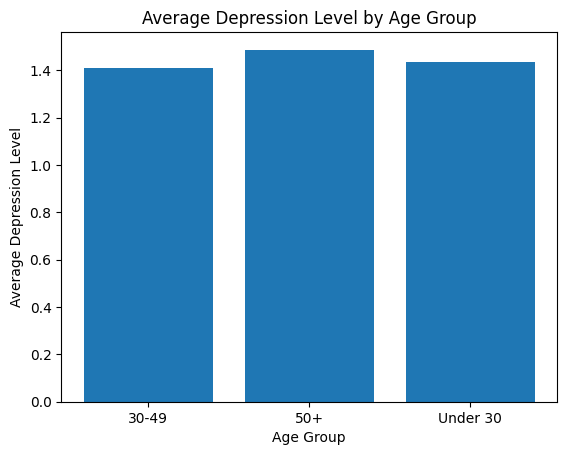

In [31]:
import matplotlib.pyplot as plt

plt.bar(pandas_df["age_group"], pandas_df["avg_depression"])
plt.xlabel("Age Group")
plt.ylabel("Average Depression Level")
plt.title("Average Depression Level by Age Group")
plt.show()


In [32]:
# Аналіз середнього рівня депресії за статтю
avg_depression_by_gender = clean_df.groupBy("gndr").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_gender.show()


+----+------------------+
|gndr|    avg_depression|
+----+------------------+
|   1|1.3799211535345899|
|   2|1.5228445622839828|
+----+------------------+



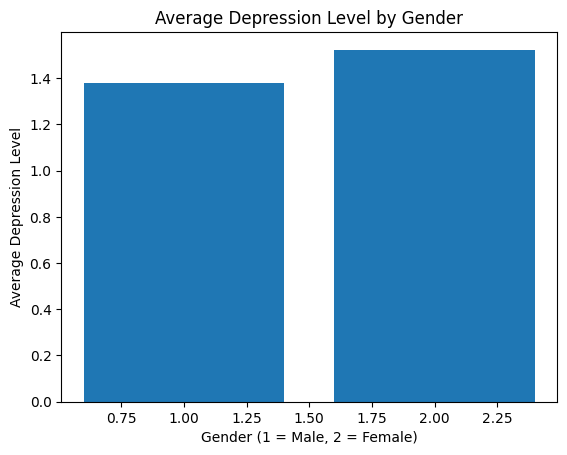

In [33]:
pandas_gender = avg_depression_by_gender.toPandas()

import matplotlib.pyplot as plt

plt.bar(pandas_gender["gndr"], pandas_gender["avg_depression"])
plt.xlabel("Gender (1 = Male, 2 = Female)")
plt.ylabel("Average Depression Level")
plt.title("Average Depression Level by Gender")
plt.show()


In [34]:
# Аналіз середнього рівня депресії за доходами
avg_depression_by_income = clean_df.groupBy("hinctnta").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_income.show()


+--------+------------------+
|hinctnta|    avg_depression|
+--------+------------------+
|       1|1.7641423357664234|
|       6| 1.406501806057238|
|       3|1.5330528846153846|
|       5|1.4529239766081872|
|      88|            1.4972|
|       9| 1.311764705882353|
|       4|1.4704355350447071|
|       8|1.3183934807916182|
|       7|1.3648461325200998|
|      77|1.5027467659046607|
|      10|1.3023512123438648|
|       2| 1.603786342123056|
|      99|1.8478260869565217|
+--------+------------------+



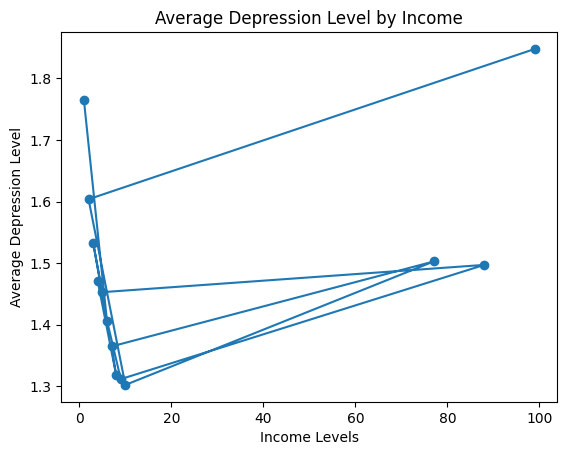

In [35]:
pandas_income = avg_depression_by_income.toPandas()

plt.plot(pandas_income["hinctnta"], pandas_income["avg_depression"], marker='o')
plt.xlabel("Income Levels")
plt.ylabel("Average Depression Level")
plt.title("Average Depression Level by Income")
plt.show()


In [38]:
correlation = clean_df.select(corr("health", "fltdpr").alias("correlation")).collect()[0]["correlation"]
print(f"Кореляція між здоров'ям і депресією: {correlation}")


Кореляція між здоров'ям і депресією: 0.29781491079215217


In [39]:
clean_df = clean_df.withColumn(
    "income_group",
    when(col("hinctnta") <= 3, "Low Income")
    .when((col("hinctnta") > 3) & (col("hinctnta") <= 6), "Middle Income")
    .otherwise("High Income")
)

avg_depression_by_income_group = clean_df.groupBy("income_group").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_income_group.show()


+-------------+------------------+
| income_group|    avg_depression|
+-------------+------------------+
|Middle Income|1.4427808506580202|
|  High Income|1.3966334526458353|
|   Low Income|1.6174805378627035|
+-------------+------------------+



In [40]:
avg_depression_by_gender_income = clean_df.groupBy("gndr", "income_group").agg(
    {"fltdpr": "avg"}
).withColumnRenamed("avg(fltdpr)", "avg_depression")

avg_depression_by_gender_income.show()


+----+-------------+------------------+
|gndr| income_group|    avg_depression|
+----+-------------+------------------+
|   1|  High Income|1.3284693269803454|
|   1|Middle Income|1.3790991702884234|
|   1|   Low Income|1.5344572611653358|
|   2|Middle Income| 1.502212389380531|
|   2|   Low Income|1.6725524818520698|
|   2|  High Income|1.4614150943396227|
+----+-------------+------------------+



In [41]:
avg_depression_by_age.toPandas().to_csv("avg_depression_by_age.csv", index=False)
